# Recommendations Systems
## MF for MovieLens dataset for Youtube paper

The Objective of this notebook is to create a baseline for using simple matrix factorization with the 1M MovieLens dataset.\
Our model is the classic MF, where all items and users are embedded in the same size latent space, and the model learns to maximize the scalar product of positive labeled items. As in the YouTube paper, we use the implicit approach, and so positive items are simply the movies rated by the user.\
Other movies are assumed to be less relevant.  
The YouTube task is all about predicting the **next** video the user wants to see. In the MovieLens datset, this translate to the next movie. Since we have the timestamp, and therefore the order of the previous watches, we define the test item for each user as its most recent rated movie, and use all the user's history to make the prediction.\
To compare with the exact same data, we extract the user-item pairs directly from the first dataset created for our YouTube model. This data also contains the exact same negative samples chosen for each user out of the unseen movies (100 negative samples for each positive).\
This dataset also has equal representation of different users, with 50 samples each (some with repetitions when must).
### Evaluation
In the YouTube model, we predict the next video out of **all** the videos in the dataset. If we want to be able to compare the results of the model, our evaluation of the positive item prediction must be ranked against all items.\
This is done by creating a batch of all items for each positive in the evalation. Each positive test user-item set is introduced separately (batch of 1) and a local batch of all items is sent for evaluation and ranked for this user.\
We use HR@10 as out main parameter tracked and also calculate MRR and NDCG at k=10 and k=5.


###Imports and administration:

In [1]:
# basic
# import os 
# import sys
from time import time
import zipfile
import requests
import pickle
import gdown
!pip install --upgrade --no-cache-dir gdown

# general
import warnings
import numpy as np
import pandas as pd

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# notebook
from IPython.display import display, HTML
from tqdm import tqdm
import copy


# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Embedding,Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
device

device(type='cuda')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
warnings.filterwarnings('ignore')

###Data preprocessing

As described, we import the same dataset with chosen train, test and validation items, already including the negative samples for the train set.\
From the test and val set, only the positive items are extracted.\
Negatives are replaced with all items during evaluation.

In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_project/train_10'
# with open(path , 'rb') as f:
#   (train_raw, test_raw, val_raw, n_items, max_watches, num_neg_samples) = pickle.load(f)
#   print('loaded training')

loaded training


In [2]:
url = "https://drive.google.com/file/d/1--fU4VVsoVxUMMQZ7pg4WhKiV1neFfOo/view?usp=share_link"
datasets_path = 'train_10'
gdown.download(url, datasets_path, quiet=False,fuzzy=True)

# path = './drive/My Drive/Colab Notebooks/recsys_final_project/train_10'
with open(datasets_path , 'rb') as f:
  (train_raw, test_raw, val_raw, n_items, max_watches, num_neg_samples) = pickle.load(f)
  print('loaded training')

Downloading...
From: https://drive.google.com/uc?id=1--fU4VVsoVxUMMQZ7pg4WhKiV1neFfOo
To: /content/train_10
100%|██████████| 402M/402M [00:07<00:00, 52.6MB/s]


loaded training


In [ ]:
n_samples_per_user = 50
n_users = 6040
n_items = 3953
num_neg_samples = 100

In [ ]:
labels = np.hstack((1.0, np.zeros(num_neg_samples).astype(float))) #first label is positive and the rest negatives
train = []
for u in range(n_users):
  offset = u*n_samples_per_user #50 samples were generated for user
  user_id = u+1
  user_idx_vec = (user_id*np.ones(num_neg_samples+1)).astype(int)
  for row in range(n_samples_per_user):
    indx = offset + row
    indices = train_raw[indx][-(num_neg_samples+1):].astype(int)
    train.extend(list(zip(user_idx_vec, indices, labels)))

In [ ]:
def evaluation_data(eval_data):
  items_list = np.arange(n_items)
  labels = np.hstack((1.0, np.zeros(n_items-1).astype(float)))
  eval = []
  for u in range(n_users):
    user_id = u+1
    item_id = eval_data[u][-(num_neg_samples+1)].astype(int)
    eval.extend([(user_id, item_id, 1.0)]) #extract only the positives
  return eval

In [ ]:
val = evaluation_data(val_raw)

In [ ]:
test = evaluation_data(test_raw)

In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_project/MF_baseline'
# with open(path, 'wb') as f:
#   pickle.dump((train, val, test), f)

In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_project/MF_baseline'
# with open(path , 'rb') as f:
#   (train, val, test) = pickle.load(f)
#   print('loaded training')

In [ ]:
dl_val = DataLoader(val, batch_size=1, shuffle=False) #precomputed since batch size must be 1 for evaluation

In [ ]:
dl_test = DataLoader(test, batch_size=1, shuffle=False) #precomputed since batch size must be 1 for evaluation

###Architecture

Classic MF model with user and item embeddings and a scalar product + sigmoid.

In [ ]:
class MF(torch.nn.Module):
    def __init__(self, config):
        super(MF, self).__init__()
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim_mf = config['latent_dim']

        self.embedding_user_mf = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_mf = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)
        mf_vector =torch.mul(user_embedding_mf, item_embedding_mf)
        mf_logit = mf_vector.sum(dim = 1)
        output = self.sigmoid(mf_logit)
        return output

###Training

We train with binary cross entropy loss and Adam optimizer.


In [ ]:
class Training(object):

  def __init__(self, model, config):
    self.config = config
    self.model = model.to(self.config['device'])
    self.optimizer = config['optimizer_type'](model.parameters(), **config['optimizer_parameter'])
    self.criterion = config['criterion']()
    self.dl_train = DataLoader(train, batch_size=config['batch_size'], shuffle=True) # create dataloader with given batch size
    self.items_list = np.arange(n_items)
    self.eval_labels = torch.tensor(np.hstack((1.0, np.zeros(n_items-1).astype(float))))

  def train(self):
    self.train_loss_history = []
    self.eval_loss_history = []
    self.eval_HR5_history = []
    self.eval_HR10_history = []
    self.eval_MRR5_history = []
    self.eval_NDCG5_history = []
    self.eval_MRR10_history = []
    self.eval_NDCG10_history = []

    epochs_without_improvement = 0
    best_HR = None 
    train_start = time()
    for epoch in range(self.config['n_epochs']):
      self.train_epoch() #train
      self.train_loss_history.append(self.epoch_train_loss/len(self.dl_train))
      if epoch%1 == 0:
        self.evaluate_epoch(dl_val) #evaluate
        # aggregate metrics
        self.eval_loss_history.append(self.epoch_eval_loss/len(dl_val))
        self.eval_HR5_history.append(self.epoch_HR5/len(dl_val))
        self.eval_HR10_history.append(self.epoch_HR10/len(dl_val))
        self.eval_MRR5_history.append(self.epoch_MRR5/len(dl_val))
        self.eval_NDCG5_history.append(self.epoch_NDCG5/len(dl_val))
        self.eval_MRR10_history.append(self.epoch_MRR10/len(dl_val))
        self.eval_NDCG10_history.append(self.epoch_NDCG10/len(dl_val))
        print(f'epoch {epoch}: loss = {self.train_loss_history[-1]}, HR@10 = {self.eval_HR10_history[-1]}')
        #check for early stopping
        if not best_HR or self.eval_HR10_history[-1] > best_HR:
          best_HR = self.eval_HR10_history[-1]
          best_MRR10 = self.eval_MRR10_history[-1]
          best_NDCG10 = self.eval_NDCG10_history[-1]
          best_loss = self.eval_loss_history[-1]
          epochs_without_improvement = 0
          #print ("Achieved lower validation loss, save model at epoch number {} ".format(epoch + 1) )
          best_model = copy.deepcopy(self.model.state_dict())
        else:
          epochs_without_improvement += 1

        if epochs_without_improvement == self.config['early_stopping']:
          if self.config['verbose']:
              print('\nEarly stoping after {} epochs. validation loss did not imporve for more than {} epcochs'.format(epoch, self.config['early_stopping']))
          break
      self.training_time = time() - train_start

    # load best model and best performance
    self.model.load_state_dict(best_model)
    if self.config['verbose']:
        print('\nFinished Training:')
        print('Best metrics are:')
        print(f'Hit Ratio eval = {best_HR}')
        print(f'MRR@10 eval= {best_MRR10}')
        print(f'NDCG@10 eval= {best_NDCG10}')
    
  def train_epoch(self):
    self.epoch_train_loss   = 0
    self.model.train() # train mode
    for batch in tqdm(self.dl_train, disable=(not self.config['verbose'])):
      self.train_batch(batch)

  def train_batch(self, batch):
    user_indices, item_indices, labels = batch      
    # Send tensors to GPU
    user_indices = user_indices.to(device)
    item_indices = item_indices.to(device)
    labels = labels.to(device)           
        
    pred = self.model(user_indices, item_indices).type(torch.float64)
    loss = self.criterion(pred, labels)
              
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()               
    self.epoch_train_loss += loss.item()

  def evaluate_epoch(self, dl_eval):
    self.epoch_eval_loss = 0
    self.epoch_HR5 = 0
    self.epoch_HR10 = 0
    self.epoch_MRR5 = 0
    self.epoch_NDCG5 = 0
    self.epoch_MRR10 = 0
    self.epoch_NDCG10 = 0

    self.model.eval() #evaluation mode
    with torch.no_grad():
      for batch in tqdm(dl_eval, disable=(not self.config['verbose'])):
        self.eval_batch(batch) # dl_val was built so that one batch is one user

  def eval_batch(self, batch):
    user_id, target_item, label = batch
    #Here we reorder the list of all items, to rank them all
    items_list_del = np.delete(self.items_list, target_item, axis=0)
    indices = np.hstack((target_item, items_list_del))
    user_idx_vec = (user_id*np.ones(n_items))

    # Send tensors to GPU
    user_indices = torch.tensor(user_idx_vec).int().to(self.config['device'])
    item_indices = torch.tensor(indices).int().to(self.config['device'])    
        
    pred = self.model(user_indices, item_indices).detach().cpu()
    ind = np.argsort(-pred) #indices to sort pred, descending
    
    ranked_items = indices[ind]
    self.epoch_HR5 += self.HitRatio(ranked_items, target_item, 5)
    self.epoch_HR10 += self.HitRatio(ranked_items, target_item, 10)
    self.epoch_MRR5 += self.MRR(ranked_items, target_item, 5)
    self.epoch_MRR10 += self.MRR(ranked_items, target_item, 10)
    self.epoch_NDCG5 += self.NDCG(ranked_items, target_item, 5)
    self.epoch_NDCG10 += self.NDCG(ranked_items, target_item, 10)
  
    loss = self.criterion(pred.type(torch.float64), self.eval_labels)         
    self.epoch_eval_loss += loss.item()

  def HitRatio(self, ranked_items, target_item, k):
    for item in ranked_items[:k]:
      if item == target_item:
        return 1
    return 0

  def MRR(self, ranked_items, target_item, k):
    for i, item in enumerate(ranked_items[:k]):
      if item == target_item:
        return 1/(i + 1)
    return 0


  def NDCG(self, ranked_items, target_item, k):
    for i, item in enumerate(ranked_items[:k]):
      if item == target_item:
        return np.log(2)/np.log(i + 2)
    return 0


###Hyperparameters

Accidently ran hyperparameters evaluation on the test set...
So a bit overfitting the results


In [ ]:
results = pd.DataFrame(columns=['latent dim', 'Batch Size', 'Learning Rate', 'Topk', 'Metric', 'Score']) #uncomment to run

In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_MF_results'
# with open(path , 'rb') as f:
#   results = pickle.load(f)
#   print('loaded results')

loaded results


In [4]:
url = "https://drive.google.com/file/d/1vGKQA8PRWA5IChDpiMkQS4fYHYbw1z-d/view?usp=sharing"
hyper_results_path = 'hyper_results'
gdown.download(url, hyper_results_path, quiet=False,fuzzy=True)

# path = './drive/My Drive/Colab Notebooks/recsys_final_hyper_results_mf''
with open(hyper_results_path , 'rb') as f:
  (results) = pickle.load(f)
  print('loaded training')

Downloading...
From: https://drive.google.com/uc?id=1vGKQA8PRWA5IChDpiMkQS4fYHYbw1z-d
To: /content/hyper_results
100%|██████████| 2.15k/2.15k [00:00<00:00, 2.25MB/s]

loaded training


In [ ]:
def add_results(training_model, results_df, latent_dim, batch_size, lr):
  loss = training_model.epoch_eval_loss/len(dl_val)
  hr5 = training_model.epoch_HR5/len(dl_val)
  hr10 = training_model.epoch_HR10/len(dl_val)
  mrr5 = training_model.epoch_MRR5/len(dl_val)
  mrr10 = training_model.epoch_MRR10/len(dl_val)
  ndcg5 = training_model.epoch_NDCG5/len(dl_val)
  ndcg10 = training_model.epoch_NDCG10/len(dl_val)
  tr_time = training_model.training_time

  results_df.loc[len(results_df)] = latent_dim, batch_size, lr, 0, 'LOSS', loss
  results_df.loc[len(results_df)] = latent_dim, batch_size, lr, 0, 'TIME', tr_time
  results_df.loc[len(results_df)] = latent_dim, batch_size, lr, 5, 'HR' , hr5
  results_df.loc[len(results_df)] = latent_dim, batch_size, lr, 10, 'HR', hr10
  results_df.loc[len(results_df)] = latent_dim, batch_size, lr, 5, 'MRR', mrr5
  results_df.loc[len(results_df)] = latent_dim, batch_size, lr, 10, 'MRR', mrr10
  results_df.loc[len(results_df)] = latent_dim, batch_size, lr, 5, 'NDCG', ndcg5
  results_df.loc[len(results_df)] = latent_dim, batch_size, lr, 10, 'NDCG', ndcg10

In [ ]:
batch_size = 64
lr = 0.001
latent_dims = [16, 32, 64, 128]

for dim in latent_dims:
  torch.manual_seed(55)
  np.random.seed(55)
  MF_config = {'num_users': 6041, 'num_items': n_items, 'latent_dim': dim}
  model_MF = MF(MF_config)

  training_config = {'batch_size': batch_size, 'optimizer_type': Adam, 'optimizer_parameter': {'lr': lr}, \
                  'criterion' : torch.nn.BCELoss, 'n_epochs' : 10, 'early_stopping' : 3, 'verbose' : True, 'device' : device}

  training_mf = Training(model_MF, training_config)
  training_mf.train()
  training_mf.evaluate_epoch(dl_test) #finally, evaluating in the test dataset

  add_results(training_mf, results, dim, batch_size, lr)

100%|██████████| 6040/6040 [00:08<00:00, 707.55it/s]


epoch 0: loss = 0.1617589775084607, HR@10 = 0.022019867549668875


100%|██████████| 6040/6040 [00:08<00:00, 712.46it/s]


epoch 1: loss = 0.0671435507208437, HR@10 = 0.02748344370860927


100%|██████████| 6040/6040 [00:08<00:00, 712.51it/s]


epoch 2: loss = 0.06353519438521217, HR@10 = 0.028145695364238412


100%|██████████| 6040/6040 [00:08<00:00, 703.69it/s]


epoch 3: loss = 0.0631692536123731, HR@10 = 0.028311258278145696


100%|██████████| 6040/6040 [00:08<00:00, 722.15it/s]


epoch 4: loss = 0.06345855163596402, HR@10 = 0.026158940397350994


100%|██████████| 6040/6040 [00:08<00:00, 730.47it/s]


epoch 5: loss = 0.06401124501428096, HR@10 = 0.027980132450331124


100%|██████████| 6040/6040 [00:08<00:00, 732.16it/s]


epoch 6: loss = 0.0647008223670844, HR@10 = 0.02913907284768212


100%|██████████| 6040/6040 [00:08<00:00, 735.72it/s]


epoch 7: loss = 0.06531107747836196, HR@10 = 0.02682119205298013


100%|██████████| 6040/6040 [00:08<00:00, 741.64it/s]


epoch 8: loss = 0.06584320927590924, HR@10 = 0.026158940397350994


100%|██████████| 6040/6040 [00:08<00:00, 748.28it/s]


epoch 9: loss = 0.06628634684977697, HR@10 = 0.02185430463576159

Early stoping after 9 epochs. validation loss did not imporve for more than 3 epcochs

Finished Training:
Best metrics are:
Hit Ratio eval = 0.02913907284768212
MRR@10 eval= 0.009053597708399053
NDCG@10 eval= 0.013687072895676103


100%|██████████| 6040/6040 [00:08<00:00, 717.76it/s]


epoch 0: loss = 0.2027793741818783, HR@10 = 0.021688741721854303


100%|██████████| 6040/6040 [00:08<00:00, 717.94it/s]


epoch 1: loss = 0.061310671504610906, HR@10 = 0.02466887417218543


100%|██████████| 6040/6040 [00:08<00:00, 718.81it/s]


epoch 2: loss = 0.05740111341822625, HR@10 = 0.026158940397350994


100%|██████████| 6040/6040 [00:08<00:00, 715.05it/s]


epoch 3: loss = 0.056447245040628764, HR@10 = 0.02466887417218543


100%|██████████| 6040/6040 [00:08<00:00, 722.32it/s]


epoch 4: loss = 0.05621649573572402, HR@10 = 0.02433774834437086


100%|██████████| 6040/6040 [00:08<00:00, 715.36it/s]


epoch 5: loss = 0.05622078236949074, HR@10 = 0.02632450331125828


100%|██████████| 6040/6040 [00:08<00:00, 706.06it/s]


epoch 6: loss = 0.05642635237060915, HR@10 = 0.0228476821192053


100%|██████████| 6040/6040 [00:08<00:00, 728.75it/s]


epoch 7: loss = 0.056648876341611094, HR@10 = 0.026655629139072847


100%|██████████| 6040/6040 [00:08<00:00, 737.90it/s]


epoch 8: loss = 0.05700639046803105, HR@10 = 0.027980132450331124


100%|██████████| 6040/6040 [00:08<00:00, 734.90it/s]


epoch 9: loss = 0.05733836841614741, HR@10 = 0.027317880794701987

Finished Training:
Best metrics are:
Hit Ratio eval = 0.027980132450331124
MRR@10 eval= 0.0077807999579522814
NDCG@10 eval= 0.012370191769559166


100%|██████████| 6040/6040 [00:08<00:00, 718.41it/s]


epoch 0: loss = 0.3204832837956976, HR@10 = 0.021688741721854303


100%|██████████| 6040/6040 [00:08<00:00, 716.16it/s]


epoch 1: loss = 0.059820790164597716, HR@10 = 0.023344370860927152


100%|██████████| 6040/6040 [00:08<00:00, 722.87it/s]


epoch 2: loss = 0.05361215548221726, HR@10 = 0.025


100%|██████████| 6040/6040 [00:08<00:00, 710.57it/s]


epoch 3: loss = 0.05199445285436909, HR@10 = 0.02367549668874172


100%|██████████| 6040/6040 [00:08<00:00, 720.70it/s]


epoch 4: loss = 0.051442466388594524, HR@10 = 0.02566225165562914


100%|██████████| 6040/6040 [00:08<00:00, 733.23it/s]


epoch 5: loss = 0.051418569154546345, HR@10 = 0.02433774834437086


100%|██████████| 6040/6040 [00:08<00:00, 726.27it/s]


epoch 6: loss = 0.051409041808244293, HR@10 = 0.02433774834437086


100%|██████████| 6040/6040 [00:08<00:00, 738.81it/s]


epoch 7: loss = 0.05161616972923945, HR@10 = 0.026986754966887416


100%|██████████| 6040/6040 [00:08<00:00, 742.84it/s]


epoch 8: loss = 0.05181065429427276, HR@10 = 0.026655629139072847


100%|██████████| 6040/6040 [00:08<00:00, 729.04it/s]


epoch 9: loss = 0.052092835152568684, HR@10 = 0.028145695364238412

Finished Training:
Best metrics are:
Hit Ratio eval = 0.028145695364238412
MRR@10 eval= 0.007774624198465266
NDCG@10 eval= 0.012409055514155


100%|██████████| 6040/6040 [00:08<00:00, 720.31it/s]


epoch 0: loss = 0.741789274614675, HR@10 = 0.020695364238410598


100%|██████████| 6040/6040 [00:08<00:00, 737.85it/s]


epoch 1: loss = 0.06843308885476128, HR@10 = 0.020860927152317882


100%|██████████| 6040/6040 [00:08<00:00, 720.96it/s]


epoch 2: loss = 0.05350180610827438, HR@10 = 0.01903973509933775


100%|██████████| 6040/6040 [00:08<00:00, 740.52it/s]


epoch 3: loss = 0.048022491524290695, HR@10 = 0.020695364238410598


100%|██████████| 6040/6040 [00:08<00:00, 707.39it/s]


epoch 4: loss = 0.04536992019571154, HR@10 = 0.02152317880794702


100%|██████████| 6040/6040 [00:08<00:00, 720.26it/s]


epoch 5: loss = 0.043703808646313895, HR@10 = 0.020364238410596026


100%|██████████| 6040/6040 [00:08<00:00, 727.59it/s]


epoch 6: loss = 0.04252931908424658, HR@10 = 0.021357615894039735


100%|██████████| 6040/6040 [00:08<00:00, 695.05it/s]


epoch 7: loss = 0.04162704323787855, HR@10 = 0.0228476821192053


100%|██████████| 6040/6040 [00:08<00:00, 746.05it/s]


epoch 8: loss = 0.04083685857333121, HR@10 = 0.02119205298013245


100%|██████████| 6040/6040 [00:08<00:00, 730.31it/s]


epoch 9: loss = 0.04016264806214388, HR@10 = 0.01870860927152318

Finished Training:
Best metrics are:
Hit Ratio eval = 0.0228476821192053
MRR@10 eval= 0.006718832124461265
NDCG@10 eval= 0.010406434606711446


100%|██████████| 6040/6040 [00:08<00:00, 743.24it/s]


In [ ]:
results

,latent dim,Batch Size,Learning Rate,Topk,Metric,Score
0,16,64,0.001,0,LOSS,0.020086
1,16,64,0.001,0,TIME,5304.148051
2,16,64,0.001,5,HR,0.012086
3,16,64,0.001,10,HR,0.025828
4,16,64,0.001,5,MRR,0.005546
5,16,64,0.001,10,MRR,0.007376
6,16,64,0.001,5,NDCG,0.007147
7,16,64,0.001,10,NDCG,0.011586
8,32,64,0.001,0,LOSS,0.028753
9,32,64,0.001,0,TIME,5889.399993


In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_hyper_results_mf'
# with open(path, 'wb') as f:
#   pickle.dump((results), f)

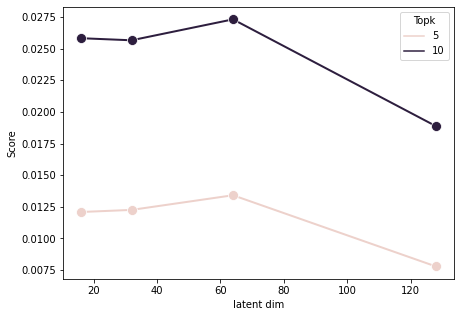

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(7,5))
HR_results = results[(results['Metric'] == 'HR')]
r = sns.lineplot(data = HR_results, x = 'latent dim', y = 'Score', hue = 'Topk', ax = ax1, marker="o", linewidth = 2, markersize=10)

In [ ]:
best_results = pd.DataFrame(columns=['latent dim', 'Batch Size', 'Learning Rate', 'Topk', 'Metric', 'Score']) #uncomment to run

In [ ]:
batch_size = 64
lr = 0.001
latent_dims = 64

torch.manual_seed(55)
np.random.seed(55)
MF_config = {'num_users': 6041, 'num_items': n_items, 'latent_dim': latent_dims}
model_MF = MF(MF_config)

training_config = {'batch_size': batch_size, 'optimizer_type': Adam, 'optimizer_parameter': {'lr': lr}, \
                'criterion' : torch.nn.BCELoss, 'n_epochs' : 12, 'early_stopping' : 3, 'verbose' : True, 'device' : device}

training_mf = Training(model_MF, training_config)
training_mf.train()
training_mf.evaluate_epoch(dl_test) #finally, evaluating in the test dataset

add_results(training_mf, best_results, latent_dims, batch_size, lr)

100%|██████████| 6040/6040 [00:08<00:00, 732.63it/s]


epoch 0: loss = 0.3204832837956976, HR@10 = 0.021688741721854303


100%|██████████| 6040/6040 [00:08<00:00, 750.31it/s]


epoch 1: loss = 0.059820790164597716, HR@10 = 0.023344370860927152


100%|██████████| 6040/6040 [00:07<00:00, 755.10it/s]


epoch 2: loss = 0.05361215548221726, HR@10 = 0.025


100%|██████████| 6040/6040 [00:08<00:00, 731.48it/s]


epoch 3: loss = 0.05199445285436909, HR@10 = 0.02367549668874172


100%|██████████| 6040/6040 [00:08<00:00, 728.73it/s]


epoch 4: loss = 0.051442466388594524, HR@10 = 0.02566225165562914


100%|██████████| 6040/6040 [00:08<00:00, 732.80it/s]


epoch 5: loss = 0.051418569154546345, HR@10 = 0.02433774834437086


100%|██████████| 6040/6040 [00:08<00:00, 751.17it/s]


epoch 6: loss = 0.051409041808244293, HR@10 = 0.02433774834437086


100%|██████████| 6040/6040 [00:08<00:00, 695.91it/s]


epoch 7: loss = 0.05161616972923945, HR@10 = 0.026986754966887416


100%|██████████| 6040/6040 [00:08<00:00, 736.38it/s]


epoch 8: loss = 0.05181065429427276, HR@10 = 0.026655629139072847


100%|██████████| 6040/6040 [00:08<00:00, 736.54it/s]


epoch 9: loss = 0.052092835152568684, HR@10 = 0.028145695364238412


100%|██████████| 6040/6040 [00:08<00:00, 737.12it/s]


epoch 10: loss = 0.05233336180614733, HR@10 = 0.03145695364238411


100%|██████████| 6040/6040 [00:08<00:00, 727.98it/s]


epoch 11: loss = 0.05255790392854328, HR@10 = 0.025165562913907286

Finished Training:
Best metrics are:
Hit Ratio eval = 0.03145695364238411
MRR@10 eval= 0.00857983811626197
NDCG@10 eval= 0.013776422388647487


100%|██████████| 6040/6040 [00:08<00:00, 737.24it/s]


NameError: ignored

In [ ]:
add_results(training_mf, best_results, latent_dims, batch_size, lr)

In [ ]:
best_results

,latent dim,Batch Size,Learning Rate,Topk,Metric,Score
0,64,64,0.001,0,LOSS,0.054320
1,64,64,0.001,0,TIME,6700.343946
2,64,64,0.001,5,HR,0.011589
3,64,64,0.001,10,HR,0.022682
4,64,64,0.001,5,MRR,0.005505
5,64,64,0.001,10,MRR,0.007007
6,64,64,0.001,5,NDCG,0.006998
7,64,64,0.001,10,NDCG,0.010606


In [ ]:
def plot_training_summary(training_model, title):
  with plt.rc_context({'lines.linewidth': 1.5, 'lines.marker' : '.', 'lines.markersize' : 8}):

    epochs = np.arange(len(training_model.train_loss_history)) + 1
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,5))
    ax1.plot(epochs, training_model.train_loss_history, 'r', label = 'train loss')
    # ax1.plot(epochs, training_model.eval_loss_history, 'orange', label = 'eval loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LogLoss')
    ax1.legend()
    ax2.plot(epochs, training_model.eval_HR5_history, 'b', label = 'Hit Ratio @5')
    ax2.plot(epochs, training_model.eval_HR10_history, 'g', label = 'Hit Ratio @10')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Hit Ratio')
    ax2.legend()
    ax3.plot(epochs, training_model.eval_MRR5_history, 'b', label = 'MRR@5')
    ax3.plot(epochs, training_model.eval_MRR10_history, 'g', label = 'MRR@10')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('MRR')
    ax3.legend()
    ax4.plot(epochs, training_model.eval_NDCG5_history, 'b', label = 'NDCG@5')
    ax4.plot(epochs, training_model.eval_NDCG10_history, 'g', label = 'NDCG@10')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('NDCG')
    ax4.legend()
    fig.suptitle(title, fontsize = 16)

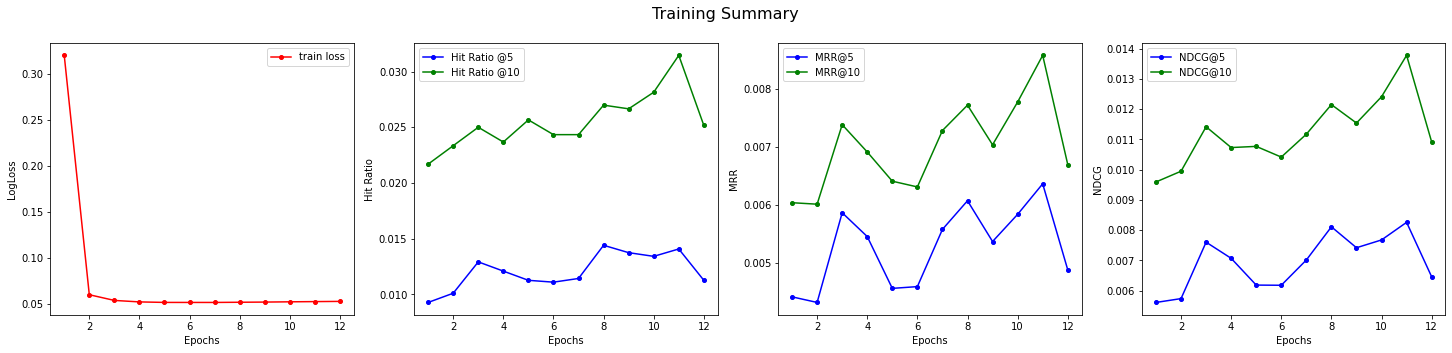

In [ ]:
plot_training_summary(training_mf, 'Training Summary')

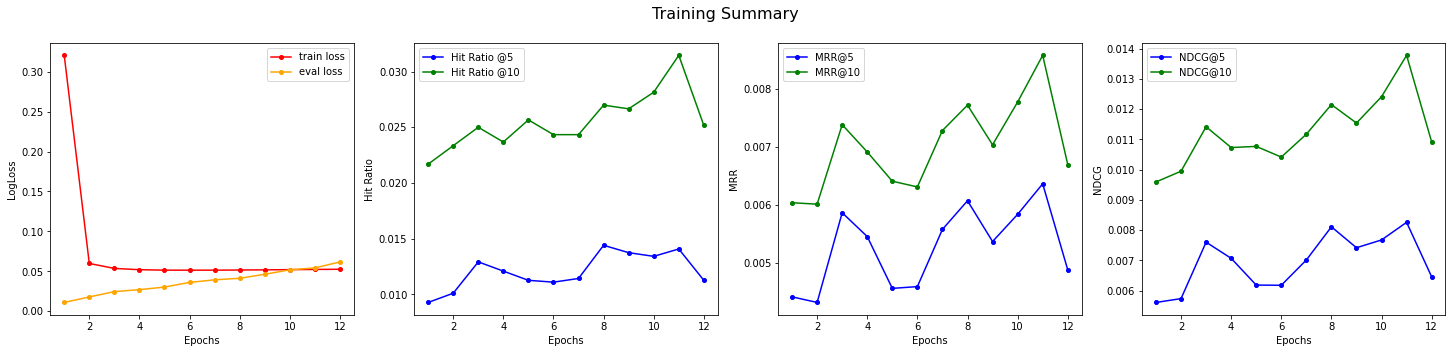

In [ ]:
plot_training_summary(training_mf, 'Training Summary')

In [ ]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_project/MF_baseline_best_results'
# with open(path, 'wb') as f:
#   pickle.dump((best_results), f)

Conclusions:

Evaluation on the test set shows that this model was able to place the target movie in the first 10 places out of all movies in 2.2% of the cases. This is compared to the 9.7% achieved with the YouTube model.

###Leftovers of quick hyperparameters search (learning rate and embedding size) 

In [ ]:
batch_size = 64
lr = 0.0005
predictive = 32

torch.manual_seed(55)
np.random.seed(55)
MF_config = {'num_users': 6041, 'num_items': n_items, 'latent_dim': predictive}
# MF_config = {'num_users': 6040, 'num_items': n_items, 'latent_dim': predictive}
model_MF = MF(MF_config)

training_config = {'batch_size': batch_size, 'optimizer_type': Adam, 'optimizer_parameter': {'lr': lr}, \
                'criterion' : torch.nn.BCELoss, 'n_epochs' : 1, 'early_stopping' : 8, 'verbose' : True, 'device' : device}

training_mf = Training(model_MF, training_config)
training_mf.train()
training_mf.evaluate_epoch(dl_test) #finally, evaluating in the test dataset

add_results(training_mf, results, predictive, batch_size, lr)

100%|██████████| 6040/6040 [00:08<00:00, 727.47it/s]


epoch 0: loss = 0.32609421802103017, HR@10 = 0.021688741721854303

Finished Training:
Best metrics are:
Hit Ratio eval = 0.021688741721854303
MRR@10 eval= 0.006127995900346895
NDCG@10 eval= 0.009679727678637588


100%|██████████| 6040/6040 [00:08<00:00, 719.84it/s]


In [ ]:
batch_size = 64
lr = 0.005
predictive = 32

torch.manual_seed(55)
np.random.seed(55)
MF_config = {'num_users': 6041, 'num_items': n_items, 'latent_dim': predictive}
# MF_config = {'num_users': 6040, 'num_items': n_items, 'latent_dim': predictive}
model_MF = MF(MF_config)

training_config = {'batch_size': batch_size, 'optimizer_type': Adam, 'optimizer_parameter': {'lr': lr}, \
                'criterion' : torch.nn.BCELoss, 'n_epochs' : 1, 'early_stopping' : 8, 'verbose' : True, 'device' : device}

training_mf = Training(model_MF, training_config)
training_mf.train()
training_mf.evaluate_epoch(dl_test) #finally, evaluating in the test dataset

add_results(training_mf, results, predictive, batch_size, lr)

100%|██████████| 6040/6040 [00:08<00:00, 695.75it/s]


epoch 0: loss = 0.11863615174417491, HR@10 = 0.016721854304635762

Finished Training:
Best metrics are:
Hit Ratio eval = 0.016721854304635762
MRR@10 eval= 0.004332229580573951
NDCG@10 eval= 0.007149701622846448


100%|██████████| 6040/6040 [00:08<00:00, 703.78it/s]


In [ ]:
batch_size = 64
lr = 0.001
predictive = 64

torch.manual_seed(55)
np.random.seed(55)
MF_config = {'num_users': 6041, 'num_items': n_items, 'latent_dim': predictive}
# MF_config = {'num_users': 6040, 'num_items': n_items, 'latent_dim': predictive}
model_MF = MF(MF_config)

training_config = {'batch_size': batch_size, 'optimizer_type': Adam, 'optimizer_parameter': {'lr': lr}, \
                'criterion' : torch.nn.BCELoss, 'n_epochs' : 1, 'early_stopping' : 8, 'verbose' : True, 'device' : device}

training_mf = Training(model_MF, training_config)
training_mf.train()
training_mf.evaluate_epoch(dl_test) #finally, evaluating in the test dataset

add_results(training_mf, results, predictive, batch_size, lr)

100%|██████████| 6040/6040 [00:08<00:00, 718.93it/s]


epoch 0: loss = 0.3204832837956976, HR@10 = 0.021688741721854303

Finished Training:
Best metrics are:
Hit Ratio eval = 0.021688741721854303
MRR@10 eval= 0.006036870598128878
NDCG@10 eval= 0.009591349368551152


100%|██████████| 6040/6040 [00:08<00:00, 699.82it/s]


In [ ]:
training_mf.epoch_HR10/len(dl_val)

0.02185430463576159

In [ ]:
batch_size = 64
lr = 0.001
predictive = 32

torch.manual_seed(55)
np.random.seed(55)
MF_config = {'num_users': 6041, 'num_items': n_items, 'latent_dim': predictive}
model_MF = MF(MF_config)

training_config = {'batch_size': batch_size, 'optimizer_type': Adam, 'optimizer_parameter': {'lr': lr}, \
                'criterion' : torch.nn.BCELoss, 'n_epochs' : 10, 'early_stopping' : 3, 'verbose' : True, 'device' : device}

training_mf = Training(model_MF, training_config)
training_mf.train()
training_mf.evaluate_epoch(dl_test) #finally, evaluating in the test dataset

add_results(training_mf, results, predictive, batch_size, lr)

100%|██████████| 6040/6040 [00:08<00:00, 701.15it/s]


epoch 0: loss = 0.2027793741818783, HR@10 = 0.021688741721854303


100%|██████████| 6040/6040 [00:08<00:00, 713.84it/s]


epoch 1: loss = 0.061310671504610906, HR@10 = 0.02466887417218543


100%|██████████| 6040/6040 [00:08<00:00, 719.68it/s]


epoch 2: loss = 0.05740111341822625, HR@10 = 0.026158940397350994


100%|██████████| 6040/6040 [00:08<00:00, 713.63it/s]


epoch 3: loss = 0.056447245040628764, HR@10 = 0.02466887417218543


  2%|▏         | 10612/476594 [00:15<11:37, 667.77it/s]


KeyboardInterrupt: ignored

In [ ]:
training_mf.evaluate_epoch(dl_test) #finally, evaluating in the test dataset

100%|██████████| 6040/6040 [00:08<00:00, 695.88it/s]


In [ ]:
training_mf.epoch_HR10/len(dl_val)

0.028642384105960265